# Project - Color Compression

## Student Information

- Họ và tên: Phạm Minh mẫn
- MSSV: 22127257
- Lớp: 22CLC01

## Importing necessary library

In [22]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
import sys

## Helper functions

In [23]:


def read_img(img_path):
    '''
    Read image from img_path

    Parameters
    ----------
    img_path : str
        Path of image

    Returns
    -------
        Image (2D)
    '''
    img = Image.open(img_path)
    pixel = img.load()

    rgb_array = []
    for i in range(img.size[1]):
        temp = []
        for j in range(img.size[0]):
            r,g,b = pixel[j,i]
            temp.append([r,g,b])
        rgb_array.append(temp)
    return np.array(rgb_array)


def show_img(img_2d, title = ''):
    plt.figure(figsize=(10, 10))
    plt.imshow(img_2d)
    plt.title(title)
    plt.show()


def save_img(img_2d, save_name, file_format = 'jpg'):
    '''
    Save image to img_path

    Parameters
    ----------
    img_2d : <your type>
        Image (2D)
    img_path : str
        Path of image
    '''

    #support jpg, png, pdf, jpeg
    if (file_format == 'jpg') | (file_format == 'png') | (file_format == 'pdf') | (file_format == 'jpeg'):
        img_path = save_name + '.' + file_format
    else:
        img_path = save_name + '.jpg'
    
    img = Image.fromarray(img_2d.astype(np.uint8))
    img.save(img_path)


def convert_img_to_1d(img_2d):
    '''
    Convert 2D image to 1D image

    Parameters
    ----------
    img_2d : <your type>
        Image (2D)

    Returns
    -------
        Image (1D)
    '''

    return img_2d.reshape(img_2d.shape[0] * img_2d.shape[1],img_2d.shape[2])




In [24]:
''' 
THIS SECTION IS DEDICATED TO MAXPOOLING
'''

#Function to get sub matrix from a matrix
def get_sub_matrix(A, irow, icol, row_size, col_size):
    '''
    Parameters:
        A : 2D array 
        irow, icol : int 
            index of row and column to start the sub matrix
        row_size, col_size : int
            size of the sub matrix
    Output:
        sub_matrix : 2D array
            sub matrix of A, start from A[irow][icol] with size row_size x col_size
    '''
    n_row = A.shape[0]
    n_col = A.shape[1]
    sub_matrix = []
    for i in range(irow, irow + row_size):
        if i >= n_row :
            break
        temp = []
        for j in range(icol, icol + col_size):
            if j >= n_col:
                break
            temp.append(A[i][j])
        sub_matrix.append(temp)
    return sub_matrix


#Function to get max value for each color R,G,B
def max_color(window):
    '''
    Parameters:
        window : 2D array
            A pooling window
    Output:
        max_red, max_green, max_blue : int
            max value for each color R,G,B
    '''
    window = convert_img_to_1d(np.array(window))
    max_red = 0
    max_green = 0
    max_blue = 0

    #iterating through the window to get the max value for each color
    for vector in window:
        if vector[0] > max_red:
            max_red = vector[0]
        if vector[1] > max_green:
            max_green = vector[1]
        if vector[2] > max_blue:
            max_blue = vector[2]
    return max_red, max_green, max_blue

#Max pooling function
def max_pooling(A, pool_size = 2, stride = 2):
    '''
    Parameters:
        A : 2D array
            Image
        pool_size : int
            Size of pooling window
        stride : int
            Stride value
    Output:
        output : 2D array
            Image after max pooling
    '''
    n_row = A.shape[0]
    n_col = A.shape[1]

    output = []
    
    for i in range(0, n_row, stride):
        temp = []
        for j in range(0, n_col, stride):
            pool_window = get_sub_matrix(A,i,j,pool_size, pool_size)    #get the pooling window
            max_red, max_green, max_blue = max_color(pool_window)     #get the max value for each color
            temp.append([max_red,max_green,max_blue]) 
        output.append(temp) #append the values to the output
    
    return np.array(output)


In [25]:
#Additional function to do Kmeans
#Calculate mean of array
def mean(A):
    return np.mean(A, axis = 0)


def distance(p1, p2):
    return np.sqrt(np.sum((p1 - p2)**2))

#Calculate within cluster sum of squares
def WCSS(data, centroids, labels):
    '''
    Parameters:
        data : 1D array of RGB values
            Image
        centroids : 1D array
            Centroids of clusters
        labels : 1D array
            Labels of clusters
    Output:
        wcss : float
            Within cluster sum of squares
    '''
    wcss = 0
    for i in range(len(centroids)):
        wcss += np.sum((data[labels == i] - centroids[i])**2)
    return wcss

#Set centroid from in_pixels
def set_centroids_initpix(data, k):
    '''
    Parameters:
        data : 1D array of RGB values
            Image
        k : int
            Number of clusters
    Output:
        centroids : 1D array
            Centroids of clusters 
    '''
    return data[np.random.choice(data.shape[0], k, replace=False)].astype(float)

#Set centroid from random
def set_centroids_random(data, k, min = 0, max = 255):
    '''
    Parameters:
        data : 1D array of RGB values
            Image
        k : int
            Number of clusters
        min : int
            Min value for random
        max : int
            Max value for random
    Output:
        centroids : 1D array
            Centroids of clusters
    '''
    centroids = []
    while len(centroids) < k:
        temp = np.random.randint(min, max+1, data.shape[1])
        temp = tuple(temp)
        if temp not in centroids: #avoid duplicate centroids
            centroids.append(temp)
    return np.array(centroids).astype(float)

#Set centroids kmeans ++
#Reference : https://www.geeksforgeeks.org/ml-k-means-algorithm/
def set_centroids_plus(data, k):
    '''
    Parameters:
        data : 1D array
            Image
        k : int
            Number of clusters
    Output:
        centroids : 1D array
            Centroids of clusters
    '''
    centroids = []
    centroids.append(data[np.random.randint(data.shape[0]), :])

    #iterating through the data points 
    for i in range(k-1):
        distances = np.linalg.norm(data[:, np.newaxis] - centroids, axis=2)
        new_centroid = data[np.argmax(np.min(distances, axis=1))]
        centroids.append(new_centroid) #new centroid is the farthest point from the previous centroids
    
    return np.array(centroids).astype(float)

#Function run K means once, do iterations and return centroids and labels
def run_iterations(data,k, iterations = 100, init_centroids = 'random'):
    '''
    Parameters:
        data : 1D array
            Image
        k : int
            Number of clusters
        iterations : int
            Number of max iterations
        init_centroids : str
            Method to initialize centroids
    '''
    #centroids is set from 1 of these methods
    centroids = []
   
    if init_centroids == 'in_pixels':
        centroids = set_centroids_initpix(data, k)
    elif init_centroids == 'plus':
        centroids = set_centroids_plus(data, k)
    else:
        centroids = set_centroids_random(data, k)

    centroids_change = True #Check if centroids dont change between 2 iterations
    iterations_count = 0

    while iterations_count < iterations and centroids_change:
        centroids_change = False 

        centroids_distances = np.linalg.norm(data[:, np.newaxis] - centroids, axis=2)   #Calculate distance between data points and centroids
        labels = np.argmin(centroids_distances, axis=1) #Assign labels to data points based on the closest centroid
      
        
        new_centroids = []
        for i in range(k):
            clustered_points = data[labels == i]
            #New centroids is the mean of the points in cluster or itself if no points in cluster
            if(clustered_points.size > 0):
                mean_point = mean(clustered_points)
            else:
                mean_point = centroids[i]
            new_centroids.append(mean_point)
            
        new_centroids = np.array(new_centroids)

        if np.allclose(new_centroids, centroids, atol=0.1): #Compare previous centroids with new centroids, tolerance = 0.1
            centroids = new_centroids
            centroids_change = False
        else:
            centroids = new_centroids
            iterations_count += 1
            centroids_change = True
       
    return centroids, labels    #return centroids and labels


#Function to run kmeans mulitple time, get best centroids using WCSS
def iterative_kmeans(data, k, iterations=100, init_centroids = "random", attemps = 1):
    '''
    Parameters:
        data : 1D array
            Image
        k : int
            Number of clusters
        iterations : int
            Number of max iterations
        init_centroids : str
            Method to initialize centroids
        attemps : int
            Number of attemps
    Output:
        best_centroids : 1D array
            Best centroids
    '''

    best_centroids = []
    labels = []
    min_wcss = float('inf')

    for attemps_count in range(attemps):
        current_centroids, labels = run_iterations(data,k, iterations=iterations, init_centroids=init_centroids)    #Run kmeans once


        current_wcss = WCSS(data, current_centroids, labels)    #Calculate WCSS
        if current_wcss < min_wcss:
            best_centroids = current_centroids  #assign wcss and best centroids if current wcss is less than min wcss
            min_wcss = current_wcss
        
    
    return best_centroids

def kmeans(img_1d, k_clusters, max_iter, init_centroids='random'):
    '''
    K-Means algorithm

    Parameters
    ----------
    img_1d : np.ndarray with shape=(height * width, num_channels)
        Original (1D) image
    k_clusters : int
        Number of clusters
    max_iter : int
        Max iterator
    init_centroids : str, default='random'
        The method used to initialize the centroids for K-means clustering
        'random' --> Centroids are initialized with random values between 0 and 255 for each channel
        'in_pixels' --> A random pixel from the original image is selected as a centroid for each cluster

    Returns
    -------
    centroids : np.ndarray with shape=(k_clusters, num_channels)
        Stores the color centroids for each cluster
    labels : np.ndarray with shape=(height * width, )
        Stores the cluster label for each pixel in the image
    '''
    #get best centroids from running kmeans multiple times
    best_centroids = iterative_kmeans(img_1d, k_clusters, max_iter, init_centroids, attemps = 1)


    centroids_distances = np.linalg.norm(img_1d[:, np.newaxis] - best_centroids, axis=2)
    labels = np.argmin(centroids_distances, axis=1) #assign labels

    
    return best_centroids, labels   #return centroids and labels

def generate_2d_img(img_2d_shape, centroids, labels):
    '''
    Generate a 2D image based on K-means cluster centroids

    Parameters
    ----------
    img_2d_shape : tuple (height, width, 3)
        Shape of image
    centroids : np.ndarray with shape=(k_clusters, num_channels)
        Store color centroids
    labels : np.ndarray with shape=(height * width, )
        Store label for pixels (cluster's index on which the pixel belongs)

    Returns
    -------
        New image (2D)
    '''
    output = centroids[labels].astype(int)
    output = output.reshape(img_2d_shape)
    return output


#This is alternate version of generate_2d_img, because max pooling returns the labels of pooled image, we have to assign lables for the original image outside
def generate_2d_from_centroids(img_2d, centroids):
    '''
    Generate a 2D image based on K-means cluster centroids
    parameters:
        img_2d : 2D array
            Original image
        centroids : 1D array
            Centroids of clusters
    Output:
        output : 2D array
            Image after K-means clustering
    '''
    img_1d = convert_img_to_1d(img_2d)
    centroids = np.array(centroids)

    #Calculate distance
    centroids_distances = np.linalg.norm(img_1d[:, np.newaxis] - centroids, axis=2) 
    labels = np.argmin(centroids_distances, axis=1) #Assign labels to data points based on the closest centroid
    output = centroids[labels].astype(int)  #assign value based on labels
    output = output.reshape(img_2d.shape)   #reshape the output to 2D
    return output

## Tests

In [26]:
#To calculate run time
import time


#Demo run k-means
def demo (): 

    path = "gato.jpeg"  #path to image
    img_2d = read_img(path) #read image into 2D array

    img_1d = convert_img_to_1d(img_2d) #flatten the image to 1D array
    k_clusters = 7 #number of clusters

    start = time.time()
    centroids, labels = kmeans(img_1d, k_clusters, max_iter=100, init_centroids='plus') #run kmeans
    end = time.time()
    print("Time taken for Kmeans: ", end - start)

    print(centroids)

    new_img = generate_2d_img(img_2d.shape, centroids, labels) #generate image from centroids and labels

    print("Original Image: ")
    show_img(img_2d, title = "Original Image")

    print("Image after reduced to %d color: " % k_clusters)
    show_img(new_img, title = "Image after reduced to %d color" % k_clusters)

    output_name = "output_" + str(k_clusters) + "_color"
    save_img(new_img, output_name, file_format = 'jpg') #save image


#demo kmeans with max pooling
def demo_pooling():
    path = "gato.jpeg"
    img_2d = read_img(path)
    
    pooled_img_2d = max_pooling(img_2d, pool_size = 5, stride = 5)  #max pooling with pool size 5 and stride 5
    pooled_img_1d = convert_img_to_1d(pooled_img_2d) #flatten the image to 1D array

    k_clusters = 50 #number of clusters
    start = time.time()
    centroids, labels = kmeans(pooled_img_1d, k_clusters, max_iter=100, init_centroids='plus') #run kmeans
    end = time.time()
    print("Time taken for Kmeans: ", end - start)

    print(centroids)

    start = time.time()
    new_img = generate_2d_from_centroids(img_2d, centroids)
    end = time.time()
    print("Time taken for generating image: ", end - start)


    print("Original Image: ")
    show_img(img_2d, title = "Original Image")


    print("Image after reduced to %d color: " % k_clusters)
    show_img(new_img, title = "Image after reduced to %d color" % k_clusters)

    output_name = "output_" + str(k_clusters) + "_color"
    save_img(new_img, output_name, file_format = 'jpg') #save image


## Main Function

In [27]:

#main function
def main():
    file_path = ""
    file_path = input("Enter the path of the image: ") #input path of the image
    if not os.path.exists(file_path):
        print("File not found")
        sys.exit()
   
    img_2d = read_img(file_path) #read image into 2D array
    print("Image loaded successfully")
    show_img(img_2d)

    k_clusters = int(input("Enter the number of clusters: ")) #input number of clusters, default 1
    if k_clusters < 1:
        print("Invalid number of clusters, using 1")
        k_clusters = 1

    init_centroids = input("Enter the method to initialize centroids (random, in_pixels, plus): ") #input method to initialize centroids
    if init_centroids not in ['random', 'in_pixels', 'plus']:
        print("Invalid method, using random")
        init_centroids = 'random' #default random
    
    max_iter = int(input("Enter the maximum number of iterations: ")) #input max number of iterations, default 1
    if max_iter < 1:
        print("Invalid number of iterations, using 1")
        max_iter = 1
    
    img_1d = convert_img_to_1d(img_2d)

    centroids, labels = kmeans(img_1d, k_clusters, max_iter, init_centroids) #run kmeans
    print("Kmeans completed successfully")

    new_img = generate_2d_img(img_2d.shape, centroids, labels) #generate image from centroids and labels
    print("Image after reduced to %d color: " % k_clusters)
    show_img(new_img)

    output_name = input("Enter the name of the output file: ") #input name of the output file
    format = input("Enter the format of the output file (jpg, png, pdf, jpeg): ") #input format of the output file, default jpg
    if format not in ['jpg', 'png', 'pdf', 'jpeg']:
        print("Invalid format, using jpg")
        format = 'jpg'
    
    save_img(new_img, output_name, format) #save image
    print("Image saved successfully")

Image loaded successfully


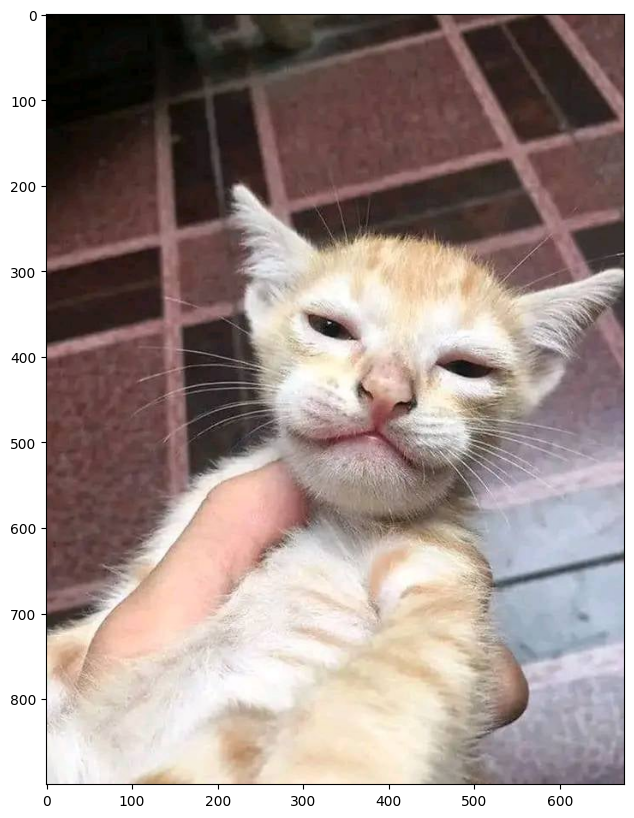

Kmeans completed successfully
Image after reduced to 7 color: 


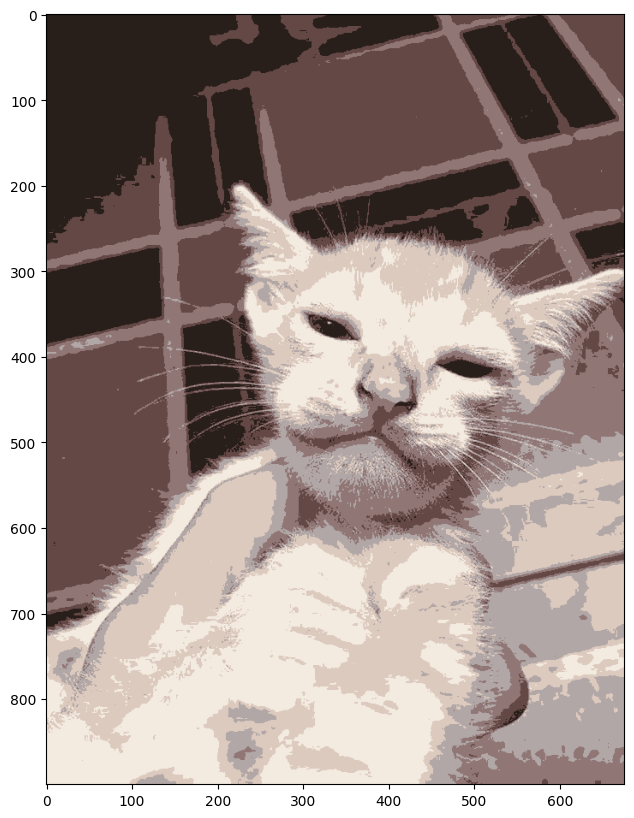

Image saved successfully


In [28]:
# Call main function
main()